# Setting the mass and stiffness matrices

In [1]:
import numpy as np
from scipy import linalg
import math


m = np.diag([1,1,1]) # mass matrix
k = np.matrix('2 -1 0;-1 2 -1;0 -1 1') # stiffness matrix

T1_ref = 1 # time period [sec]

w1_ref = 2*math.pi/T1_ref # frequency [rad/sec]
print('Frequency of structure is: '+str(np.round(w1_ref,3))+' Hz.')

Frequency of structure is: 6.283 Hz.


# Calculation of mass and stiffness constants

In [2]:

import scipy.optimize as spo
import math


def parsdet(kvarmvar): # this function determine
    kvar = kvarmvar[0]
    mvar = kvarmvar[1]
    lval,lvec = linalg.eig(k*kvar,m*mvar)
    x = np.sqrt(lval.min())
    fun = abs(x-w1_ref)

    return fun

# starting guess
kvar_start = 500 # kN/cm
mvar_start = 10 # kN.sec2/cm

# Bounds
bnds = ((0, 30000), (0, 10000))

result = spo.minimize(parsdet,[kvar_start,mvar_start],bounds=bnds)
print(result)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 4.214761872844974e-11
        x: [ 5.001e+02  2.509e+00]
      nit: 9
      jac: [-2.148e-03  1.252e+00]
     nfev: 198
     njev: 66
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [3]:
lval,lvec = linalg.eig(k*result.x[0],m*result.x[1]) #eigenvalues, eigenvectors
result.x

array([500.12084171,   2.50909414])

# Mode shapes

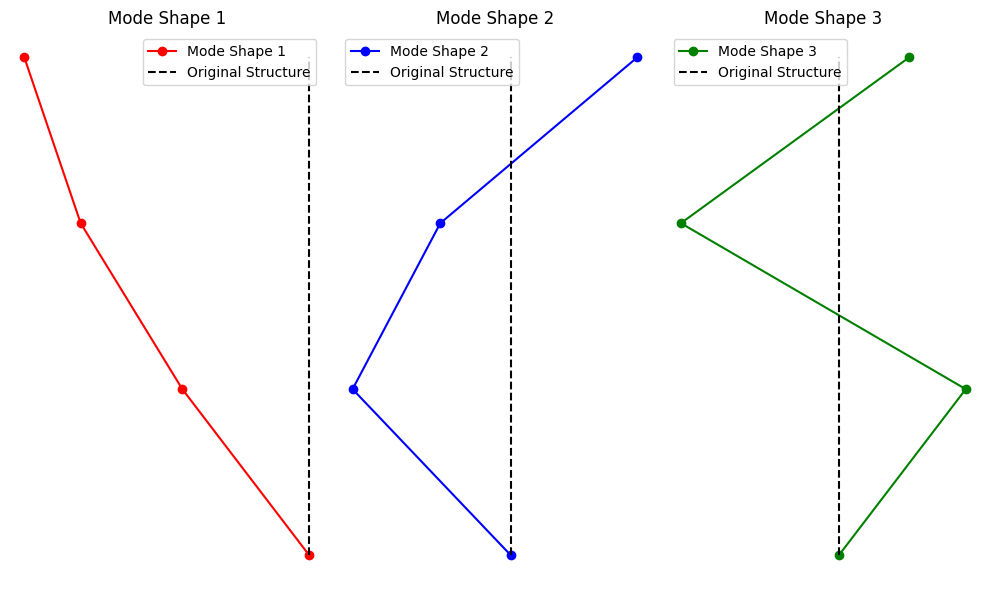

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy.linalg as sci_linalg


## defining modal parameters

k0,m0 = result.x[0],result.x[1] #stiffness constant, mass constant
w,v= sci_linalg.eig(k0*k,m0*m) # w is eigenvalues and v is eigenvectors

# Example mode shapes (eigenvectors)
mode_shape = np.vstack([[0,0,0],v])
mode_shape


# X-coordinates for nodes
x_nodes = np.arange(len(mode_shape))

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

for xi,title,color in zip([0,1,2],[1,2,3],['red','blue','green']):
# Plot mode shape 1
  ax[xi].plot(mode_shape[:,2-xi], x_nodes, marker='o', color=color, label='Mode Shape '+str(xi+1))
  ax[xi].vlines(x=0,ymin=0,ymax=3, color='black', linestyle='--', label='Original Structure')
  ax[xi].set_title('Mode Shape '+str(xi+1))
  ax[xi].set_ylabel('Storey')
  ax[xi].get_xaxis().set_visible(False)
  ax[xi].get_yaxis().set_visible(False)

  ax[xi].grid(False)
  ax[xi].yaxis.set_major_locator(MaxNLocator(integer=True))
  ax[xi].legend()
  ax[xi].spines['right'].set_visible(False)
  ax[xi].spines['top'].set_visible(False)
  ax[xi].spines['left'].set_visible(False)
  ax[xi].spines['bottom'].set_visible(False)


# Adjust layout and display plots
plt.tight_layout()

# Calculating K and M generalized matrices

In [5]:
import numpy.linalg as np_linalg

#print(w)
K = np_linalg.multi_dot([np.transpose(v),k0*k,v]) # K is modal stiffness (generalized stiffness matrix)
M = np_linalg.multi_dot([np.transpose(v),m0*m,v]) # M is modal mass (generalized mass matrix)


acc_list = np.loadtxt('https://github.com/mtareqsoliman/strucdynamics/blob/main/files/CNP100_edit.txt?raw=true',skiprows=0)*100 # needs to skip first line automatically

L = np_linalg.multi_dot([np.transpose(v),-m0*np.ones([3,1])]) # L is modal effective mass
print(K)

[[ 1.62388217e+03 -4.40070679e-13  2.76970702e-13]
 [-4.70189379e-13  7.77666970e+02  4.08028206e-14]
 [ 3.71040612e-13  2.03716350e-14  9.90550663e+01]]


# Applying Newmark-Beta Method
(linear acceleration approach)

In [6]:
import pandas as pd

def newmark(m,k,p,dt): # newmark's integration function
  ui = 0
  vi = 0
  ai = 0
  pi = 0
  a0 = (pi-k*ui)/m
  x1 = (6/(dt**2))*m
  x2 = (6/dt)*m
  x3 = 2*m
  k_ht = k+x1
  ## for loop

  u = np.zeros([p.size])
  v = np.zeros([p.size])
  a = np.zeros([p.size])
  i = 0

  for pi2 in p:
    pi2_ht = pi2+x1*ui+x2*vi+x3*ai
    ui2 = pi2_ht/k_ht
    vi2 = (3/dt)*(ui2-ui)-2*vi-0.5*dt*ai
    ai2 = (6/dt**2)*(ui2-ui)-(6/dt)*vi-2*ai
    ai = ai2
    vi = vi2
    ui = ui2
    u[i]=ui
    v[i]=vi
    a[i]=ai
    i=i+1

  nmark_table = pd.DataFrame(np.transpose([np.arange(p.size)*dt,p,u,v,a]),columns=['Time step','P(t)','U(t)','V(t)','A(t)'])  #print(a)
  print(nmark_table)
  print(nmark_table['A(t)'].values)
  return nmark_table

Ai = np.zeros([3,acc_list.size]) # acceleration will be stores here but in modal
                                 # coordinates at each storey

for i in [0,1,2]:
  Mi = M[i,i]
  Ki = K[i,i]
  Pi = L[i]*acc_list # P is modal load matrix
  dt = 0.01
  #print(Mi)
  newmark_table = newmark(Mi,Ki,Pi,dt)
  Ai[i,:] = newmark_table['A(t)'].values # this is the modal acceleration at each storey

ai = np.dot(v,Ai) # this is actual acceleration at each storey
ai

print()

#nmark_table = pd.DataFrame([i,Pi,u,v,a],label=['Time step','P(t)','U(t)','V(t)','A(t)'])

      Time step      P(t)      U(t)       V(t)        A(t)
0          0.00 -0.000000  0.000000   0.000000    0.000000
1          0.01  1.690392  0.000011   0.003333    0.666516
2          0.02  0.845196  0.000071   0.008118    0.290582
3          0.03 -0.845196  0.000155   0.007385   -0.437217
4          0.04  0.845196  0.000218   0.006179    0.196012
...         ...       ...       ...        ...         ...
2340      23.40  0.845196  0.227264 -19.219704 -146.748170
2341      23.41  0.845196  0.029859 -20.048384  -18.987866
2342      23.42  0.845196 -0.169425 -19.593382  109.988217
2343      23.43  0.845196 -0.357827 -17.883832  231.921842
2344      23.44 -0.000000 -0.523290 -15.030860  338.672439

[2345 rows x 5 columns]
[0.00000000e+00 6.66516473e-01 2.90581721e-01 ... 1.09988217e+02
 2.31921842e+02 3.38672439e+02]
      Time step      P(t)      U(t)       V(t)        A(t)
0          0.00  0.000000  0.000000   0.000000    0.000000
1          0.01 -4.401569 -0.000029  -0.008726   -1.

# Plotting of absolute acceleration

Text(0.5, 1.0, 'Frequency = 100Hz')

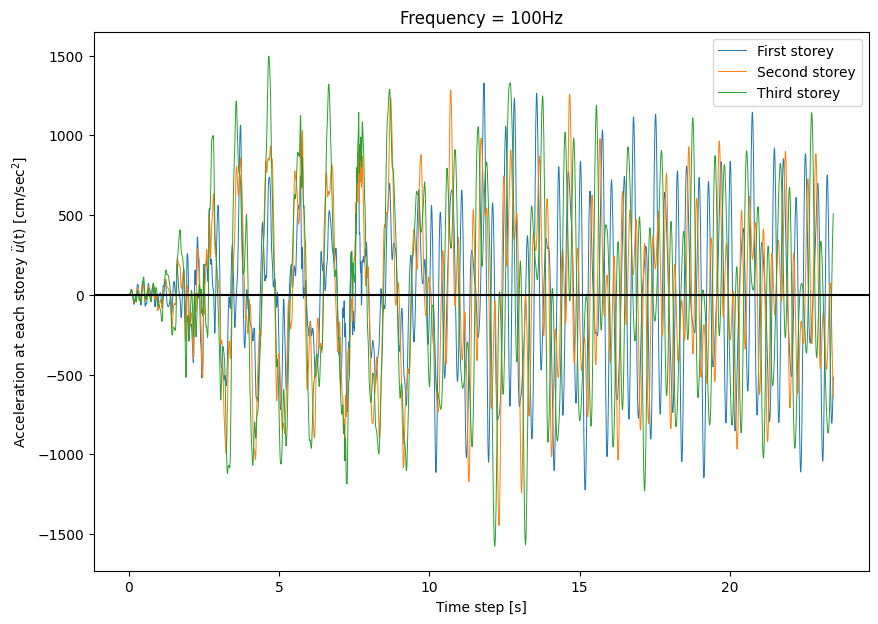

In [7]:
import matplotlib.pyplot as plt

t = np.arange(0,0+acc_list.size*dt,dt)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(t,ai[0],label='First storey',linewidth=0.7)
ax.plot(t,ai[1],label='Second storey',linewidth=0.7)
ax.plot(t,ai[2],label='Third storey',linewidth=0.7)
ax.legend()
ax.axhline(y=0, color='k')
ax.set_xlabel('Time step [s]')
ax.set_ylabel('Acceleration at each storey $\ddot u$(t) [cm/sec$^2$]')
ax.set_title('Frequency = 100Hz')

#ax = plt.plot(,ai)

     Time step       P(t)      U(t)      V(t)       A(t)
0         0.00  -0.663577 -0.000087 -0.005207  -0.208298
1         0.05   5.144248  0.000263  0.036591   1.880232
2         0.10  13.432113  0.004639  0.142376   2.351180
3         0.15  -9.938313  0.009504 -0.051636 -10.111681
4         0.20 -17.329207 -0.003452 -0.421247  -4.672741
..         ...        ...       ...       ...        ...
464      23.20   1.494967 -0.108419 -2.856669  70.764468
465      23.25   0.173536 -0.151420  1.364148  98.068187
466      23.30   1.546763 -0.000971  3.846972   1.244763
467      23.35   0.094249  0.151560  1.426792 -98.051927
468      23.40   1.692226  0.111424 -2.810475 -71.438784

[469 rows x 5 columns]
[-2.08297782e-01  1.88023168e+00  2.35117991e+00 -1.01116813e+01
 -4.67274076e+00  1.25892907e+01  1.59662048e+01 -1.15766853e+01
 -2.52505226e+01  1.13764178e+01  2.35835934e+01 -1.06201535e+01
 -1.34962871e+01  4.08369351e+00  3.79553634e+00  2.12301558e+00
  1.26062440e+01 -1.15263088e+01

Text(0.5, 1.0, 'Frequency = 20Hz')

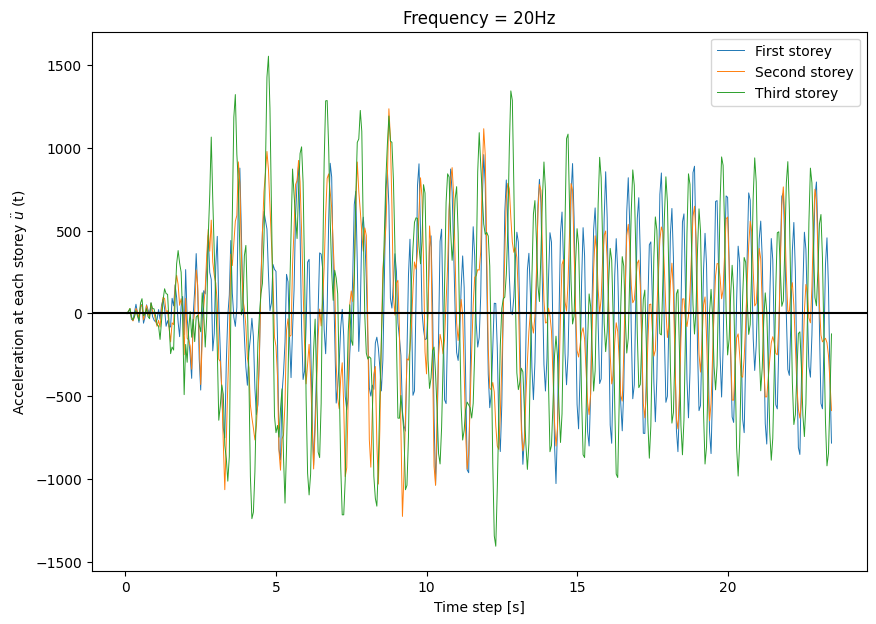

In [8]:
from scipy import signal

acc_list_res1 = signal.resample(acc_list,int(len(acc_list)*(20/100)))

Ai = np.zeros([3,acc_list_res1.size])

for i in [0,1,2]:
  Mi = M[i,i]
  Ki = K[i,i]
  Pi = L[i]*acc_list_res1 # P is modal load matrix
  dt = 0.05
  newmark_table = newmark(Mi,Ki,Pi,dt)
  Ai[i,:] = newmark_table['A(t)'].values # this is the modal acceleration at each storey

ai = np.dot(v,Ai) # this is actual acceleration at each storey

t = np.arange(0,0+acc_list_res1.size*dt,dt)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(t[1:],ai[0],label='First storey',linewidth=0.7)
ax.plot(t[1:],ai[1],label='Second storey',linewidth=0.7)
ax.plot(t[1:],ai[2],label='Third storey',linewidth=0.7)
ax.legend()
ax.axhline(y=0, color='k')
ax.set_xlabel('Time step [s]')
ax.set_ylabel('Acceleration at each storey $\ddot u$ (t)')
ax.set_title('Frequency = 20Hz')

#ax = plt.plot(,ai)

# Resampling the motion

     Time step       P(t)      U(t)      V(t)        A(t)
0          0.0   1.667285  0.000533  0.015984    0.319675
1          0.1   5.963135  0.003443  0.039368    0.148017
2          0.2 -13.719528 -0.000596 -0.207330   -5.081988
3          0.3   3.007678 -0.017449  0.163167   12.491937
4          0.4  -5.650931  0.017681  0.102990  -13.695491
..         ...        ...       ...       ...         ...
229       22.9   1.464715  0.143233  7.782528  -92.116516
230       23.0  -0.493164  0.295432 -6.393274 -191.399518
231       23.1   1.905232 -0.471759 -0.659196  306.081065
232       23.2   0.085914  0.232192  7.132861 -150.239926
233       23.3   1.115244  0.214281 -7.291039 -138.238062

[234 rows x 5 columns]
[ 3.19674845e-01  1.48017086e-01 -5.08198824e+00  1.24919374e+01
 -1.36954906e+01  8.07296881e+00 -3.05755910e+00  2.48441358e+00
 -2.15532235e+00  1.00468416e+00 -6.81292790e+00  1.39693043e+01
 -2.18182832e+00 -1.70940231e+01  5.17788939e+00  2.03029741e+01
 -6.31919630e+00 -1.

Text(0.5, 1.0, 'Frequency = 10Hz')

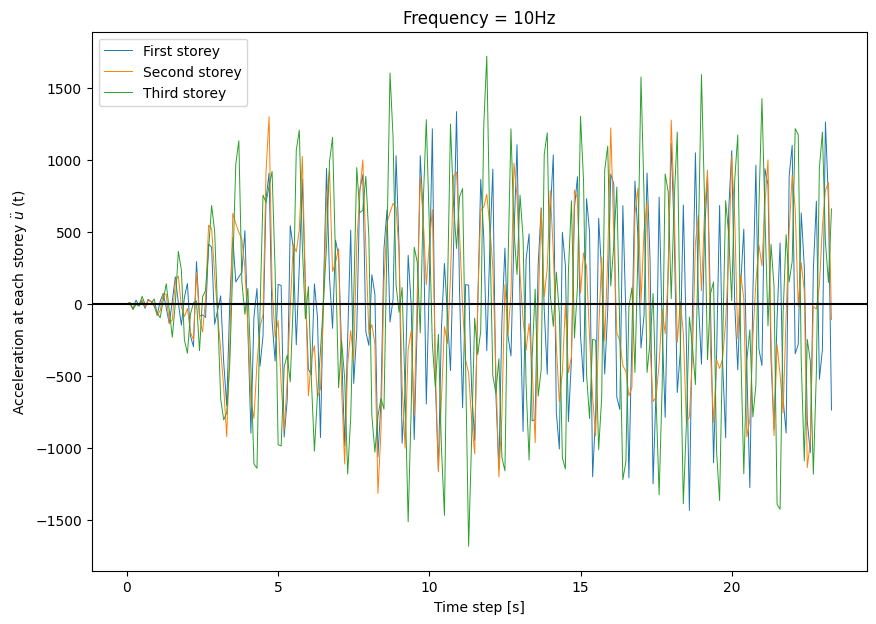

In [9]:
from scipy import signal

acc_list_res1 = signal.resample(acc_list,int(len(acc_list)*(10/100)))

Ai = np.zeros([3,acc_list_res1.size])

for i in [0,1,2]:
  Mi = M[i,i]
  Ki = K[i,i]
  Pi = L[i]*acc_list_res1 # P is modal load matrix
  dt = 0.1
  newmark_table = newmark(Mi,Ki,Pi,dt)
  Ai[i,:] = newmark_table['A(t)'].values # this is the modal acceleration at each storey

ai = np.dot(v,Ai) # this is actual acceleration at each storey

t = np.arange(0,0+acc_list_res1.size*dt,dt)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(t,ai[0],label='First storey',linewidth=0.7)
ax.plot(t,ai[1],label='Second storey',linewidth=0.7)
ax.plot(t,ai[2],label='Third storey',linewidth=0.7)
ax.legend()
ax.axhline(y=0, color='k')
ax.set_xlabel('Time step [s]')
ax.set_ylabel('Acceleration at each storey $\ddot u$ (t)')
ax.set_title('Frequency = 10Hz')

#ax = plt.plot(,ai)

     Time step       P(t)          U(t)          V(t)          A(t)
0        0.000   1.667285  6.938163e-04  1.497445e-02  2.154598e-01
1        0.139   5.963135  3.831271e-03  2.279149e-02 -1.029843e-01
2        0.278 -13.719528 -3.654754e-03 -1.999945e-01 -3.102569e+00
3        0.417   3.007678 -1.542613e-02  3.615591e-01  1.118248e+01
4        0.556  -5.650931  3.229386e-02 -4.703727e-01 -2.315272e+01
..         ...        ...           ...           ...           ...
229     31.831   1.464715 -6.381848e+21  3.329013e+22  4.130323e+24
230     31.970  -0.493164  8.056237e+21 -4.202437e+22 -5.213985e+24
231     32.109   1.905232 -1.016993e+22  5.305019e+22  6.581964e+24
232     32.248   0.085914  1.283819e+22 -6.696883e+22 -8.308857e+24
233     32.387   1.115244 -1.620651e+22  8.453926e+22  1.048883e+25

[234 rows x 5 columns]
[ 2.15459753e-01 -1.02984347e-01 -3.10256910e+00  1.11824770e+01
 -2.31527192e+01  3.99674643e+01 -6.41942315e+01  9.67423884e+01
 -1.36214759e+02  1.83848926e+

Text(0.5, 1.0, 'Frequency = 10Hz, dt = 0.139 sec')

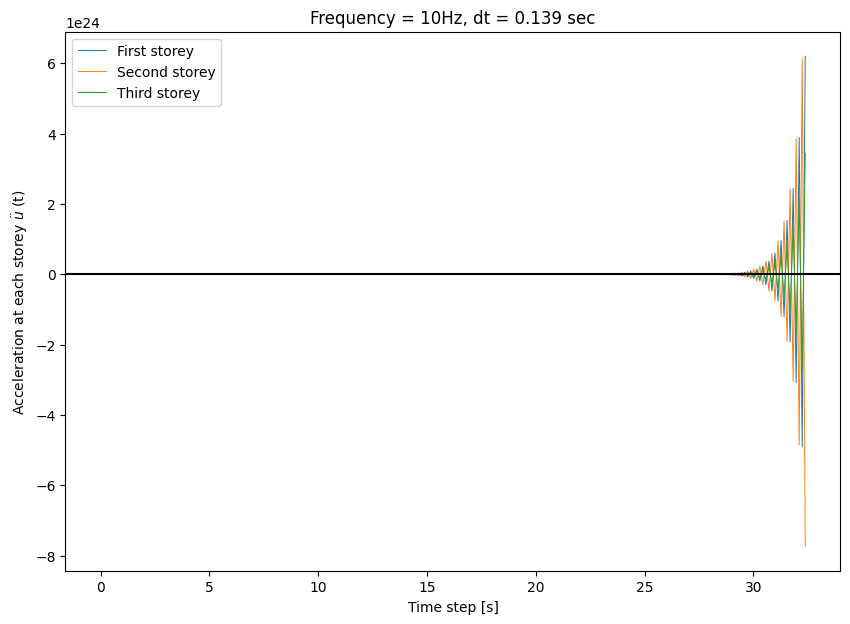

In [10]:
from scipy import signal

acc_list_res1 = signal.resample(acc_list,int(len(acc_list)*(10/100)))

Ai = np.zeros([3,acc_list_res1.size])

for i in [0,1,2]:
  Mi = M[i,i]
  Ki = K[i,i]
  Pi = L[i]*acc_list_res1 # P is modal load matrix
  dt = 0.139
  newmark_table = newmark(Mi,Ki,Pi,dt)
  Ai[i,:] = newmark_table['A(t)'].values # this is the modal acceleration at each storey

ai = np.dot(v,Ai) # this is actual acceleration at each storey

t = np.arange(0,0+acc_list_res1.size*dt,dt)
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(t,ai[0],label='First storey',linewidth=0.7)
ax.plot(t,ai[1],label='Second storey',linewidth=0.7)
ax.plot(t,ai[2],label='Third storey',linewidth=0.7)
ax.legend()
ax.axhline(y=0, color='k')
ax.set_xlabel('Time step [s]')
ax.set_ylabel('Acceleration at each storey $\ddot u$ (t)')
ax.set_title('Frequency = 10Hz, dt = 0.139 sec')

#ax = plt.plot(,ai)